# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import drive



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1897 sha256=0d1a7666c5e6c299d58689babbc1bab23c09f24bcc812b783063666838a7fa5c
  Stored in directory: /root/.cache/pip/wheels/da/5c/29/bf862cc934550145485b0e0502cb8deadffb387f6a096e4b5f
Successfully built pycrf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.1 MB/s eta 0:00:00


In [2]:
#!python -m spacy download en_core_web_sm

In [3]:
model = spacy.load("en_core_web_sm")

In [4]:
drive.mount("/content/drive") # Uncomment this to connect drive 

Mounted at /content/drive


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


# Data Importing

In [5]:
# We will be defining a function to import all necessary train and test data 
# We have been provided with train_sent, test_sent, train_label and test_label

def import_data(path, operation = "r"):
  return open(path, operation, encoding = "utf-8").readlines()

In [6]:
# Defining the path for our train sentences and labels

path = "/content/drive/MyDrive/CustomNerAssignment/Data/train_sent"
raw_training_sent = import_data(path)

path  = "/content/drive/MyDrive/CustomNerAssignment/Data/train_label"
raw_training_labels = import_data(path)

In [7]:
# Checking our imported data
print(raw_training_sent[:50])
print(raw_training_labels[:50])

['All\n', 'live\n', 'births\n', '>\n', 'or\n', '=\n', '23\n', 'weeks\n', 'at\n', 'the\n', 'University\n', 'of\n', 'Vermont\n', 'in\n', '1995\n', '(\n', 'n\n', '=\n', '2395\n', ')\n', 'were\n', 'retrospectively\n', 'analyzed\n', 'for\n', 'delivery\n', 'route\n', ',\n', 'indication\n', 'for\n', 'cesarean\n', ',\n', 'gestational\n', 'age\n', ',\n', 'parity\n', ',\n', 'and\n', 'practice\n', 'group\n', '(\n', 'to\n', 'reflect\n', 'risk\n', 'status\n', ')\n', '\n', 'The\n', 'total\n', 'cesarean\n', 'rate\n']
['O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', '\n', 'O\n', 'O\n', 'O\n', 'O\n']


In [8]:
# Defining the path for our train sentences and labels
path = "/content/drive/MyDrive/CustomNerAssignment/Data/test_sent"
raw_test_sent = import_data(path)

path  = "/content/drive/MyDrive/CustomNerAssignment/Data/test_label"
raw_test_labels = import_data(path)

In [9]:
# Checking our imported data
print(raw_test_sent[:50])
print(raw_test_labels[:50])

['Furthermore\n', ',\n', 'when\n', 'all\n', 'deliveries\n', 'were\n', 'analyzed\n', ',\n', 'regardless\n', 'of\n', 'risk\n', 'status\n', 'but\n', 'limited\n', 'to\n', 'gestational\n', 'age\n', '>\n', 'or\n', '=\n', '36\n', 'weeks\n', ',\n', 'the\n', 'rates\n', 'did\n', 'not\n', 'change\n', '(\n', '12.6\n', '%\n', ',\n', '280\n', 'of\n', '2214\n', ';\n', 'primary\n', '9.2\n', '%\n', ',\n', '183\n', 'of\n', '1994\n', ')\n', '\n', 'As\n', 'the\n', 'ambient\n', 'temperature\n', 'increases\n']
['O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', '\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n']


In [10]:
# Below is the information in the form of words which we will process them into meaningful sentences
print("Length of raw_training_sent is {}".format(len(raw_training_sent)))
print("Length of raw_training_labels is {}".format(len(raw_training_labels)))
print("Length of raw_test_sent is {}".format(len(raw_test_sent)))
print("Length of raw_test_labels is {}".format(len(raw_test_labels)))

Length of raw_training_sent is 48501
Length of raw_training_labels is 48501
Length of raw_test_sent is 19674
Length of raw_test_labels is 19674


# Data Preprocessing

We have imported all our training and test data along with the labels but as you can see we need to do some preprocessing before we start our actual preprocessing to make the sentences in the correct format

In [11]:
# We want our data to look like this
[word.split("\n")[0] for word in raw_training_sent[:30]]

['All',
 'live',
 'births',
 '>',
 'or',
 '=',
 '23',
 'weeks',
 'at',
 'the',
 'University',
 'of',
 'Vermont',
 'in',
 '1995',
 '(',
 'n',
 '=',
 '2395',
 ')',
 'were',
 'retrospectively',
 'analyzed',
 'for',
 'delivery',
 'route',
 ',',
 'indication',
 'for',
 'cesarean']

In [12]:
# Sanity checks 
# This preprocessing shoudnt hinder the length of our corpus after pre processing 
# i.e the length of our corpus before preprocessing should be equal to the length of the corpus after preprocessing
# We will try this out on a subset of our corpus

def first_preprocessing(sent):
  train_sent_temp = [word.split("\n")[0] for word in sent[0]]
  train_labels_temp = [word.split("\n")[0] for word in sent[1]]
  
  return (len(train_sent_temp), len(train_labels_temp))


print("Length of raw_training_sent before pre processing vs length of raw_training_sent after pre processing")
print(first_preprocessing([raw_training_sent[:30], raw_training_labels[:30]])[0] == len(raw_training_sent[:30]), "\n")


print("Length of raw_training_labels before pre processing vs length of raw_training_label after pre processing")
print(first_preprocessing([raw_training_sent[:30], raw_training_labels[:30]])[1] == len(raw_training_labels[:30]))

Length of raw_training_sent before pre processing vs length of raw_training_sent after pre processing
True 

Length of raw_training_labels before pre processing vs length of raw_training_label after pre processing
True


Since we got out desired results let's first convert this data into a more convenient form then merge the words to form sentences, we will do this inside one function

In [13]:
# Now we will write some logic which takes care of "\n" and sort of brings our data
# Into a more readable format and from there onwards we can learn some more features about our corpus

def preprocessor(sent):
  final_train_data = [] # Returns our final sentences or labels depending upon the inputs
  temp_sent = []

  for word in sent:
    if word == "\n":
      final_train_data.append(" ".join(temp_sent))
      temp_sent.clear()
    else:
      temp_sent.append(word.split("\n")[0])
  return final_train_data

In [14]:
training_sent = preprocessor(raw_training_sent)
training_labels = preprocessor(raw_training_labels)

test_sent = preprocessor(raw_test_sent)
test_labels = preprocessor(raw_test_labels)

In [15]:
for i in range(5):
  print("Training sent {} : {}".format(i+1, training_sent[i]))
  print("Training labels {} : {}\n".format(i+1, training_labels[i]))

  print("Test sent {} : {}".format(i+1, test_sent[i]))
  print("Test labels {} : {}\n".format(i+1, test_labels[i]))

Training sent 1 : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Training labels 1 : O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Test sent 1 : Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Test labels 1 : O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Training sent 2 : The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Training labels 2 : O O O O O O O O O O O O O O O O O O O O O O O O O

Test sent 2 : As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehy

### Count the number of sentences in the processed train and test dataset 

In [16]:
print("Length of training_sent is {}".format(len(training_sent)))
print("Length of test_sent is {}".format(len(test_sent)))

Length of training_sent is 2599
Length of test_sent is 1056


### Count the number of lines of labels in the processed train and test dataset.

In [17]:
print("Length of training_labels is {}".format(len(training_labels)))
print("Length of test_labels is {}".format(len(test_labels)))

Length of training_labels is 2599
Length of test_labels is 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



In [18]:
# For this we need the entire dataset i.e merging our train_sentences and test_sentences

complete_data = training_sent + test_sent
print(len(complete_data)) # 2599 + 1056 = 3655

3655


### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [19]:
# Now we will determine the top 25 most common tokens with tags of NOUN or PRONOUN with the help of the following function
def get_most_common(pos_tags = ("PROPN", "NOUN"), top_most = 25):
# this fucntion will either return top most occuring words according to their pos tags or the entire dataframe depending upon the input

  most_common_df = pd.DataFrame(columns = ["Text", "Pos"])

  for sent in complete_data:
    doc = model(sent)
    for token in doc:
      if token.pos_ in pos_tags:
        most_common_df = pd.concat([most_common_df, pd.DataFrame({"Text" : [token.text], "Pos" : [token.pos_]})], 
                                     axis = 0)
        
  most_common_df.reset_index(inplace = True)

  if top_most == "all":
    return most_common_df
  else:
    return most_common_df["Text"].value_counts()[:top_most]

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [20]:
get_most_common() 

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
risk             71
surgery          71
cases            71
analysis         70
rate             67
response         66
survival         65
children         64
Name: Text, dtype: int64

In [21]:
top_25 = get_most_common()

### EDA for top 25 most common occuring tokens

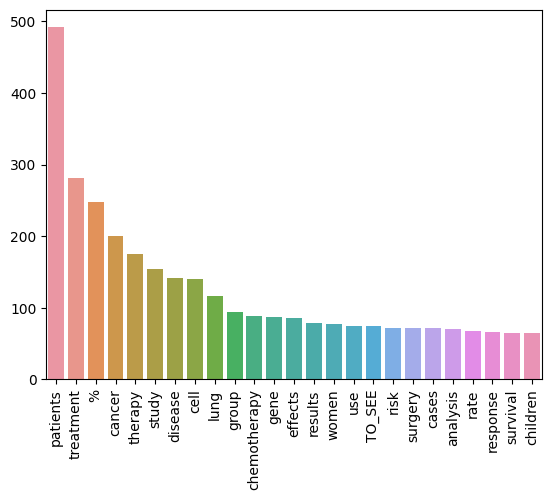

<Figure size 1700x1000 with 0 Axes>

In [22]:
sns.barplot(x = top_25.index, y = top_25.values)
plt.xticks(ticks = range(0,25), labels = top_25.index, rotation = 90)
plt.show()
plt.gcf().set_size_inches((17,10))

## Defining features for CRF

## Now we will define some feature f1 till fn which will help us extract features out of sentences; more specifically for each word 
- F1 : words in lower
- F2 : Last 4 characters
- F3 : Last 3 characters
- F4 : Last 2 characters
- F5 : Every character in a word is in CAPS
- F6 : First character is a capital letter or no
- F7 : If the word is a title
- F8 : If the character is a digit
- F9 : Pos tags



Well this a list of features for now, further for the previous word we can define other set of features and improve them



In [23]:
# Let's define the features to get the feature value for one word.
# features = [
#       "word.lower=" + word.lower(),    # converts word to all lowercase
#       "word[-4:]=" + word[-4:],        # Last 4 character of a word
#       "word[-3:]=" + word[-3:],        # Last 3 characters of a word
#       "word[-2]=" + word[-2:],         # Last 2 characters of a word
#       "word.allcaps=%s" % word.isupper(),   # If the word is in all CAPS
#       "word.startswithCap=%s" % word[0].isupper(), # If the word starts with a capital letter
#       "word.isTitle=%s" % word.istitle(), # If the word is a title
#       "word.isdigit=%s" % word.isdigit(), # If the word is a digit
#       "word.pos=" + str(list_of_postags[pos])] # pos of that word



## Getting the features

In [24]:
# Now let's get the pos tag of training set and we will define evrything in a function 
def getFeaturesOfSent(proc_sent, pos):
  #proc_doc = model(sent)
  list_of_postags = []
  for token in proc_sent:
    list_of_postags.append(token.pos_)

  sent = str(proc_sent).split()
  word = sent[pos]

  features = [
      "word.lower=" + word.lower(),    # converts word to all lowercase
      "word[-4:]=" + word[-4:],        # Last 4 character of a word
      "word[-3:]=" + word[-3:],        # Last 3 characters of a word
      "word[-2]=" + word[-2:],         # Last 2 characters of a word
      "word.allcaps=%s" % word.isupper(),   # If the word is in all CAPS
      "word.startswithCap=%s" % word[0].isupper(), # If the word starts with a capital letter
      "word.isTitle=%s" % word.istitle(), # If the word is a title
      "word.isdigit=%s" % word.isdigit(), # If the word is a digit
      "word.pos=" + str(list_of_postags[pos])] # pos of that word

  if pos > 0:
    prev_word = sent[pos - 1]
    features.extend([
        "prev_word.lower=" + prev_word.lower(),
        "prev_word.isdigit=%s" % prev_word.isdigit(),
        "prev_word.startswithCap=%s" % prev_word[0].isupper(),
        "prev_word.pos=" + str(list_of_postags[pos - 1])
    ])

  else:
    features.append("BEG")

  if pos == len(proc_sent) - 1:
    features.append("END")
  
  return features

### Function for getting features of sentences

In [25]:
model_for_feature = spacy.load("en_core_web_sm") # Defining a model 
def getFeatureForOneSent(sent):
  proc_sent = model_for_feature(sent)
  return [getFeaturesOfSent(proc_sent, pos) for pos in range(len(str(proc_sent).split()))]


### Function to get the labels of a sentence

In [26]:
def getlabels(labels):
  return [label.split() for label in labels]

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

In [27]:
# As you can see I already have my labels in the desired format but for the sake of clarity and one to one mapping 
# Let's check the length of output features and that of these labesl
# Also let's try applying our function to a particular sentence and check their output

len(getFeatureForOneSent(training_sent[0])) == len(training_labels[0].split())

True

In [28]:
sent_for_demo = training_sent[0]
print(sent_for_demo)

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


In [29]:
getFeatureForOneSent(sent_for_demo) # Demonstrating how our feature extraction works

[['word.lower=all',
  'word[-4:]=All',
  'word[-3:]=All',
  'word[-2]=ll',
  'word.allcaps=False',
  'word.startswithCap=True',
  'word.isTitle=True',
  'word.isdigit=False',
  'word.pos=DET',
  'BEG'],
 ['word.lower=live',
  'word[-4:]=live',
  'word[-3:]=ive',
  'word[-2]=ve',
  'word.allcaps=False',
  'word.startswithCap=False',
  'word.isTitle=False',
  'word.isdigit=False',
  'word.pos=ADJ',
  'prev_word.lower=all',
  'prev_word.isdigit=False',
  'prev_word.startswithCap=True',
  'prev_word.pos=DET'],
 ['word.lower=births',
  'word[-4:]=rths',
  'word[-3:]=ths',
  'word[-2]=hs',
  'word.allcaps=False',
  'word.startswithCap=False',
  'word.isTitle=False',
  'word.isdigit=False',
  'word.pos=NOUN',
  'prev_word.lower=live',
  'prev_word.isdigit=False',
  'prev_word.startswithCap=False',
  'prev_word.pos=ADJ'],
 ['word.lower=>',
  'word[-4:]=>',
  'word[-3:]=>',
  'word[-2]=>',
  'word.allcaps=False',
  'word.startswithCap=False',
  'word.isTitle=False',
  'word.isdigit=False',
  'w

In [30]:
getlabels(training_labels[0].split()) # For Labels

[['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O']]

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [31]:
X_train = [getFeatureForOneSent(sent) for sent in training_sent]
X_test = [getFeatureForOneSent(sent) for sent in test_sent]

### Define the labels as the target variable for test and the train dataset

In [32]:
y_train = getlabels(training_labels)
y_test = getlabels(test_labels)

In [33]:
X_train[:4] # Checking a subset of our training data

[[['word.lower=all',
   'word[-4:]=All',
   'word[-3:]=All',
   'word[-2]=ll',
   'word.allcaps=False',
   'word.startswithCap=True',
   'word.isTitle=True',
   'word.isdigit=False',
   'word.pos=DET',
   'BEG'],
  ['word.lower=live',
   'word[-4:]=live',
   'word[-3:]=ive',
   'word[-2]=ve',
   'word.allcaps=False',
   'word.startswithCap=False',
   'word.isTitle=False',
   'word.isdigit=False',
   'word.pos=ADJ',
   'prev_word.lower=all',
   'prev_word.isdigit=False',
   'prev_word.startswithCap=True',
   'prev_word.pos=DET'],
  ['word.lower=births',
   'word[-4:]=rths',
   'word[-3:]=ths',
   'word[-2]=hs',
   'word.allcaps=False',
   'word.startswithCap=False',
   'word.isTitle=False',
   'word.isdigit=False',
   'word.pos=NOUN',
   'prev_word.lower=live',
   'prev_word.isdigit=False',
   'prev_word.startswithCap=False',
   'prev_word.pos=ADJ'],
  ['word.lower=>',
   'word[-4:]=>',
   'word[-3:]=>',
   'word[-2]=>',
   'word.allcaps=False',
   'word.startswithCap=False',
   'word.i

In [34]:
y_train[:4] # Checking a subset our training labels

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

## Build the CRF Model

 ### Note : In the newer version of sklearn-crfsuit there seems to be an error while training our data with "tempfiles" so what I essentially did in the following code is to just by pass it and it works just fine

Link to the solution of "tempfile" problem : https://stackoverflow.com/questions/66059532/attributeerror-crf-object-has-no-attribute-keep-tempfiles

In [35]:
crf = sklearn_crfsuite.CRF(max_iterations=200)   

try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [36]:
y_pred = crf.predict(X_test)
y_pred[:4]

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [37]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average = "weighted")
round(f1_score, 3)

0.911

In [38]:
print("Sentence : {}".format(test_sent[20]))
print("Actual label : {}".format(test_labels[20]))
print("Predicted label : {}".format(y_pred[20]))

Sentence : Sequelae include severe developmental delay and asymmetric double hemiplegia
Actual label : O O O O O O O O D
Predicted label : ['O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

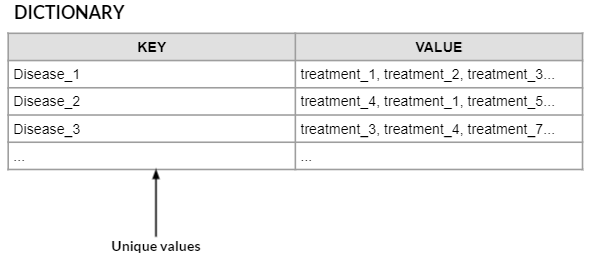

In [39]:
def clear():
  diseases.clear()
  treatments.clear()

diseases = []
treatments = []
# This block of code just makes sure that re running this cell wont affect our values starting with a clean slate
clear()
print(diseases)
print(treatments)

# Here instead of iterating through all the sentences we will iterate only through the sentences having Diseases and their respective treatments

for pred_index in range(len(y_pred)):
  if ("D" in y_pred[pred_index]) and ("T" in y_pred[pred_index]):
    temp_dis = []
    temp_treatment = []

    for pred_label in range(len(y_pred[pred_index])):

      if y_pred[pred_index][pred_label] == "D":
        temp_dis.append(test_sent[pred_index].split()[pred_label])

      elif y_pred[pred_index][pred_label] == "T":
        temp_treatment.append(test_sent[pred_index].split()[pred_label])

    diseases.extend([temp_dis])
    treatments.extend([temp_treatment])
    
    
print(diseases)  # We print the diseases 
print(treatments)  # We print the treatments 

[]
[]
[['gestational', 'diabetes', 'cases'], ['hereditary', 'retinoblastoma'], ['epilepsy'], ['unstable', 'angina', 'or', 'non-Q-wave', 'myocardial', 'infarction'], ['coronary-artery', 'disease'], ['primary', 'pulmonary', 'hypertension', '(', 'PPH', ')'], ['essential', 'hypertension'], ['foot', 'infection'], ['hemorrhagic', 'stroke'], ['cardiac', 'disease'], ['early', 'Parkinson', "'s", 'disease'], ['sore', 'throat'], ['abdominal', 'tuberculosis', 'Crohn', "'s", 'disease'], ['female', 'stress', 'urinary', 'incontinence'], ['stress', 'urinary', 'incontinence'], ['preeclampsia', '(', 'proteinuric', 'hypertension'], ['nuclear', 'genoma'], ['hyperammonemia', 'cancer'], ['major', 'pulmonary', 'embolism'], ['malignant', 'pleural', 'mesothelioma'], ['pulmonary', 'symptoms', 'attributable', 'mediastinal', 'teratomas'], ['non-obstructive', 'azoospermia'], ['testicular', 'bleeding'], ['duodenal', 'ulcer'], ['colorectal', 'cancer'], ['gastrointestinal', 'tumours'], ['restenosis'], ['Parkinson', "

In [40]:
# Let's check how many diseases and treatments our model was able to identify
print(len(diseases))
print(len(treatments))
print(len(diseases) == len(treatments)) # Sanity checks

131
131
True


In [41]:
# Now we have one to one mapping which maps every disease to its treatment
# From the above output we can observe that there are about 131 diseases and treatments identified from the corpus
# We dont know if every disease is unique so we will create a logic which returns a dictionary of disease : treatment
# Let's check the pseudocode for it

for disease, treatment in zip(diseases, treatments):
  print(" ".join(disease), "--------", [" ".join(treatment)])

gestational diabetes cases -------- ['good glycemic control']
hereditary retinoblastoma -------- ['radiotherapy']
epilepsy -------- ['Methylphenidate']
unstable angina or non-Q-wave myocardial infarction -------- ['roxithromycin']
coronary-artery disease -------- ['Antichlamydial antibiotics']
primary pulmonary hypertension ( PPH ) -------- ['fenfluramines']
essential hypertension -------- ['moxonidine']
foot infection -------- ['G-CSF treatment']
hemorrhagic stroke -------- ['double-bolus alteplase']
cardiac disease -------- ['fenfluramine-phentermine']
early Parkinson 's disease -------- ['Ropinirole monotherapy']
sore throat -------- ['Antibiotics']
abdominal tuberculosis Crohn 's disease -------- ['steroids']
female stress urinary incontinence -------- ['surgical treatment']
stress urinary incontinence -------- ['therapy']
preeclampsia ( proteinuric hypertension -------- ['intrauterine insemination with donor sperm versus intrauterine insemination']
nuclear genoma -------- ['mutage

In [42]:
# But we dont know if every disease is unique so using the logic above we will create a dictionary where each key(disease) will be unique
# So while iterating through our list of lists diseases if we encounter a term which is already present in the dictionary then it will
# simply add the treatments to that term. 
  
disease_treatment = {}
dups = [] # Keeping a track of duplicate diseases 
for disease, treatment in zip(diseases, treatments):
  conc_disease = " ".join(disease)
  conc_treatment = " ".join(treatment)
  if conc_disease not in disease_treatment.keys():
    disease_treatment.update({conc_disease : conc_treatment})
  else:
    dups.append(conc_disease)
    disease_treatment[conc_disease] += ", " + conc_treatment

In [43]:
dups # Here are the duplicate values

['small-cell lung cancer',
 'nsclc',
 'breast cancer',
 'primary cancer',
 'bronchiectasis',
 'multiple sclerosis',
 'acute myocardial infarction',
 'cancer']

In [44]:
disease_treatment["small-cell lung cancer"]
# Well it seems like this disease has two different treatments 

'chemotherapy, combination chemotherapy'

In [45]:
# But everything has been taken care of in the dictionary
# The dictionary has all the unique keys(diseases) and their respective treatments

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [46]:
disease_treatment["hereditary retinoblastoma"]

'radiotherapy'

In [47]:
# Below is the exact sent containing the disease named "hereditary retinoblastoma and its correspoding treatment"
test_sent[46]

'< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy'

## EXTRA

In [48]:
# Now we can just stop here but what if our model was only able to identify cancer and hereditary as disease while elimination retinoblastoma as a disease
# The treatment was captured pretty well but we cannot rely on simply indexing our dictionary directly and expecting a result
# What if we want to identify all the treatments related to cancer in our corpus we simply cannot index cancer from our disease_treatment
# It will turn out to be empty cause we dont have any "key" called cancer in our dictionary
# So we need to be more robust while searching treatments for diseases in our corpus
# We will use regex to achieve this task 
# The code below will output the treatments for a particular disease in general 

def search_treatment(disease, disease_treat_dict = disease_treatment):

  pattern = r".*{}.*".format(disease) # Pattern to identify treatments based on the name of disease provided
  print("Results for {} are : \n".format(disease))
  for keyword in disease_treatment.keys():
    if re.search(pattern, keyword):
      print(" Disease is : {} \n Treatments are : {}\n".format(keyword, disease_treatment[keyword]))

### Predicting the treatment for the disease named 'hereditary retinoblastoma' again using search_treatment function



In [49]:
search_treatment("hereditary retinoblastoma")

Results for hereditary retinoblastoma are : 

 Disease is : hereditary retinoblastoma 
 Treatments are : radiotherapy



In [50]:
# let's check and see if we can enter only a part of it for example retinoblastoma
search_treatment("retinoblastoma") # voila our search feature works just fine!

Results for retinoblastoma are : 

 Disease is : hereditary retinoblastoma 
 Treatments are : radiotherapy



# Some more examples of our search feature

In [51]:
search_treatment("lung cancer") # For example

Results for lung cancer are : 

 Disease is : some malignant tumors such as non-small cell lung cancer 
 Treatments are : surgery

 Disease is : locally advanced non-small-cell lung cancer ( la-nsclc ) 
 Treatments are : chemotherapy and radiotherapy )

 Disease is : limited stage small cell lung cancer 
 Treatments are : vip combination chemotherapy

 Disease is : small-cell lung cancer 
 Treatments are : chemotherapy, combination chemotherapy

 Disease is : non-hodgkin 's lymphoma mesothelioma and non-small cell lung cancer 
 Treatments are : oxaliplatin

 Disease is : non-small cell lung cancer advanced hormone refractory prostate cancer 
 Treatments are : paclitaxel and carboplatin mitoxantrone

 Disease is : primary lung cancer adenocarcinoma squamous cell carcinoma 
 Treatments are : resection

 Disease is : advanced non -- small-cell lung cancer 
 Treatments are : paclitaxel plus carboplatin ( pc ) vinorelbine plus cisplatin

 Disease is : untreated small cell lung cancer ( sclc